In [1]:
conda install -y -c conda-forge opencv

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ 

In [2]:
import PIL
import cv2 as cv
import numpy as np
import tensorflow as tf
import os, re, time, json
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

In [3]:
data_dir = '../input/caltech-birds2010'

# **Visualization Utility Functions**

In [4]:
def draw_bounding_box_on_image(image, bbox, color=(255, 0, 0), thickness=5):
    ymin, xmin, ymax, xmax = bbox
    
    image_width = image.shape[1]
    image_height = image.shape[0]
    
    rectangle = [int(xmin), int(ymin), int(xmax), int(ymax)]
    
    cv.rectangle(
                image, 
                rectangle, 
                color, 
                thickness
                )
    
def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=5):
    boxes_shape = boxes.shape
    if not boxes_shape:
        return 
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')
    for i in range(boxes_shape[0]):
        bbox = [boxes[i, 1], boxes[i, 0], boxes[i, 3],boxes[i, 2]]
        draw_bounding_box_on_image(image, bbox, color[i], thickness)
        
def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=5):
    draw_bounding_boxes_on_image(image, boxes, color, thickness)
    return image

In [5]:
# Configure Matplotlib
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

In [6]:
# utility to display a row of digits with their predictions
def display_digits_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):

    n = len(images)

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
  
    for i in range(n):
      ax = fig.add_subplot(1, 10, i+1)
      bboxes_to_plot = []
      if (len(pred_bboxes) > i):
        bbox = pred_bboxes[i]
        bbox = [bbox[0] * images[i].shape[1], bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0]]
        bboxes_to_plot.append(bbox)
    
      if (len(bboxes) > i):
        bbox = bboxes[i]
        if bboxes_normalized == True:
          bbox = [
                int(bbox[0] * images[i].shape[1]),
                int(bbox[1] * images[i].shape[0]), 
                int(bbox[2] * images[i].shape[1]), 
                int(bbox[3] * images[i].shape[0])
                                          ]
        bboxes_to_plot.append(bbox)

      img_to_draw = draw_bounding_boxes_on_image_array(
                                              image=images[i], 
                                              boxes=np.asarray(bboxes_to_plot), 
                                              color=[(255,0,0), (0, 255, 0)]
                                                    )
      plt.xticks([])
      plt.yticks([])
    
      plt.imshow(img_to_draw)

      if len(iou) > i :
        color = "black"
        if (iou[i][0] < iou_threshold):
          color = "red"
        ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color=color, transform=ax.transAxes)
        
        
# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [7]:
def read_image_tfds(image, bbox):
    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)

    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    image = tf.image.resize(image, (224, 224,))

    image = image/127.5
    image -= 1

    bbox_list = [bbox[0] / factor_x , 
                 bbox[1] / factor_y, 
                 bbox[2] / factor_x , 
                 bbox[3] / factor_y]
    
    return image, bbox_list

def read_image_with_shape(image, bbox):
    original_image = image
    
    image, bbox_list = read_image_tfds(image, bbox)
    
    return original_image, image, bbox_list

In [8]:
def read_image_tfds_with_original_bbox(data):
    image = data["image"]
    bbox = data["bbox"]

    shape = tf.shape(image)
    factor_x = tf.cast(shape[1], tf.float32) 
    factor_y = tf.cast(shape[0], tf.float32)

    bbox_list = [bbox[1] * factor_x , 
                 bbox[0] * factor_y, 
                 bbox[3] * factor_x, 
                 bbox[2] * factor_y]
    return image, bbox_list

In [9]:
def dataset_to_numpy_util(dataset, batch_size=0, N=0):

    # eager execution: loop through datasets normally
    take_dataset = dataset.shuffle(1024)

    if batch_size > 0:
        take_dataset = take_dataset.batch(batch_size)
  
    if N > 0:
        take_dataset = take_dataset.take(N)
  
    if tf.executing_eagerly():
        ds_images, ds_bboxes = [], []
        for images, bboxes in take_dataset:
            ds_images.append(images.numpy())
            ds_bboxes.append(bboxes.numpy())
        
    return (np.array(ds_images), np.array(ds_bboxes))

In [10]:
def dataset_to_numpy_with_original_bboxes_util(dataset, batch_size=0, N=0):

    normalized_dataset = dataset.map(read_image_with_shape)
    if batch_size > 0:
        normalized_dataset = normalized_dataset.batch(batch_size)
  
    if N > 0:
        normalized_dataset = normalized_dataset.take(N)

    if tf.executing_eagerly():
        ds_original_images, ds_images, ds_bboxes = [], [], []
        
    for original_images, images, bboxes in normalized_dataset:
        ds_images.append(images.numpy())
        ds_bboxes.append(bboxes.numpy())
        ds_original_images.append(original_images.numpy())

    return np.array(ds_original_images), np.array(ds_images), np.array(ds_bboxes)

In [11]:
def get_visualization_training_dataset():      
    dataset, info = tfds.load(
                        "caltech_birds2010", 
                        split="train", 
                        with_info=True, 
                        data_dir=data_dir, 
                        download=False
                            )
    visualization_training_dataset = dataset.map(read_image_tfds_with_original_bbox, 
                                                 num_parallel_calls=16)
    return visualization_training_dataset


visualization_training_dataset = get_visualization_training_dataset()

2022-01-31 16:14:48.163183: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 16:14:48.263595: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 16:14:48.264243: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 16:14:48.266583: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

2022-01-31 16:14:51.112086: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


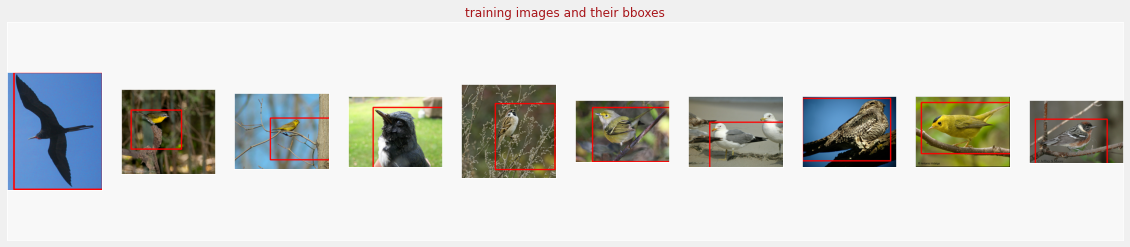

In [12]:
(visualization_training_images, visualization_training_bboxes) = dataset_to_numpy_util(visualization_training_dataset, N=10)
display_digits_with_boxes(np.array(visualization_training_images), np.array([]), np.array(visualization_training_bboxes), np.array([]), "training images and their bboxes")

In [13]:
def get_visualization_validation_dataset():
    dataset = tfds.load("caltech_birds2010", split="test", try_gcs=True, data_dir=data_dir)
    visualization_validation_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)
    return visualization_validation_dataset

visualization_validation_dataset = get_visualization_validation_dataset()

2022-01-31 16:14:57.569987: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


In [14]:
BATCH_SIZE = 64

def get_training_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(-1) 
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    return dataset

training_dataset = get_training_dataset(visualization_training_dataset)
validation_dataset = get_validation_dataset(visualization_validation_dataset)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


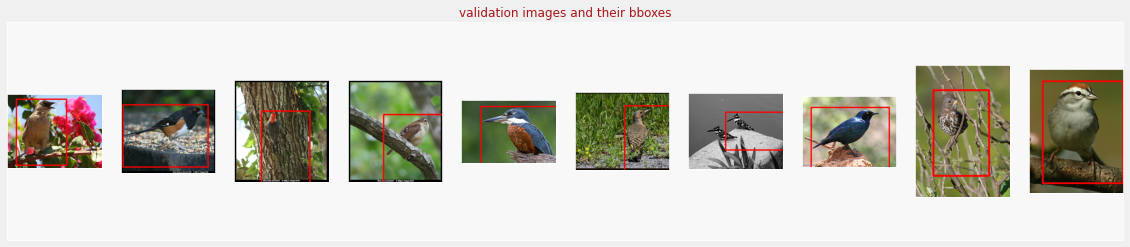

In [15]:
(visualization_validation_images, visualization_validation_bboxes) = dataset_to_numpy_util(visualization_validation_dataset, N=10)
display_digits_with_boxes(np.array(visualization_validation_images), np.array([]), np.array(visualization_validation_bboxes), np.array([]), "validation images and their bboxes")

In [16]:
def feature_extractor(inputs):
    ### YOUR CODE HERE ###
    
    # Create a mobilenet version 2 model object
    mobilenet_model = tf.keras.applications.MobileNetV2(
                                            input_shape=(224, 224, 3),
                                            include_top=False, 
                                            weights='imagenet'
                                        )

    

    # pass the inputs into this modle object to get a feature extractor for these inputs
    feature_extractor = mobilenet_model(inputs)
    

    ### END CODE HERE ###
        
    # return the feature_extractor
    return feature_extractor

In [17]:
def dense_layers(features):
    ### YOUR CODE HERE ###

    # global average pooling 2D layer.
    x = tf.keras.layers.GlobalAveragePooling2D()(features)
    
    # flatten layer
    x = tf.keras.layers.Flatten()(x)
    
    # 1024 Dense layer, with relu
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    
    # 512 Dense layer, with relu
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    
    ### END CODE HERE ###
    
    return x

In [18]:
def bounding_box_regression(x):
    ### YOUR CODE HERE ###
    
    # Dense layer named `bounding_box`
    bounding_box_regression_output = tf.keras.layers.Dense(4)(x)

    ### END CODE HERE ###
        

    return bounding_box_regression_output

In [19]:
def final_model(inputs):
    ### YOUR CODE HERE ###

    # features
    feature_cnn = feature_extractor(inputs)

    # dense layers
    last_dense_layer = dense_layers(feature_cnn) 

    # bounding box
    bounding_box_output = bounding_box_regression(last_dense_layer)
    
    # define the TensorFlow Keras model using the inputs and outputs to your model
    model = tf.keras.Model(
                        inputs=inputs,
                        outputs=bounding_box_output
                        )

    ### END CODE HERE ###
    
    
    return model

In [20]:
def define_and_compile_model():
  
    ### YOUR CODE HERE ###

    # define the input layer
    inputs = tf.keras.layers.Input(shape=(224,224,3))
    
    # create the model
    model = final_model(inputs)
    
    # compile your model
    model.compile(
              optimizer = tf.keras.optimizers.SGD(
                                            momentum=0.9
                                                ), 
              loss="mse"
    )

    ### END CODE HERE ###
    

    return model

In [21]:
# define your model
model = define_and_compile_model()
# print model layers
model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
________________________________________________________________

In [22]:
# You'll train 50 epochs
EPOCHS = 50

### START CODE HERE ###

# Choose a batch size
BATCH_SIZE = 64

# Get the length of the training set
length_of_training_dataset = len(visualization_training_dataset)

# Get the length of the validation set
length_of_validation_dataset = len(visualization_validation_dataset)

# Get the steps per epoch (may be a few lines of code)
steps_per_epoch = length_of_training_dataset // BATCH_SIZE

# get the validation steps (per epoch) (may be a few lines of code)
validation_steps = length_of_validation_dataset//BATCH_SIZE
if length_of_validation_dataset % BATCH_SIZE > 0:
    validation_steps += 1
    
### END CODE HERE

In [23]:
### YOUR CODE HERE ####

# Fit the model, setting the parameters noted in the instructions above.
history = model.fit(
              get_training_dataset(visualization_training_dataset),
              steps_per_epoch=steps_per_epoch,
              validation_data=get_validation_dataset(visualization_validation_dataset),
              validation_steps=length_of_validation_dataset // BATCH_SIZE,
              epochs=EPOCHS


)

### END CODE HERE ###

Epoch 1/50


2022-01-31 16:15:18.302859: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


46/46 [==============================] - 41s 635ms/step - loss: 0.0981 - val_loss: 0.4060
Epoch 2/50
46/46 [==============================] - 27s 598ms/step - loss: 0.0179 - val_loss: 0.2995
Epoch 3/50
46/46 [==============================] - 27s 590ms/step - loss: 0.0128 - val_loss: 0.2303
Epoch 4/50
46/46 [==============================] - 26s 578ms/step - loss: 0.0102 - val_loss: 0.1903
Epoch 5/50
46/46 [==============================] - 26s 572ms/step - loss: 0.0089 - val_loss: 0.1712
Epoch 6/50
46/46 [==============================] - 26s 568ms/step - loss: 0.0072 - val_loss: 0.1313
Epoch 7/50
46/46 [==============================] - 26s 563ms/step - loss: 0.0063 - val_loss: 0.1139
Epoch 8/50
46/46 [==============================] - 27s 583ms/step - loss: 0.0060 - val_loss: 0.0938
Epoch 9/50
46/46 [==============================] - 26s 579ms/step - loss: 0.0053 - val_loss: 0.0886
Epoch 10/50
46/46 [==============================] - 26s 563ms/step - loss: 0.0048 - val_loss: 0.0805


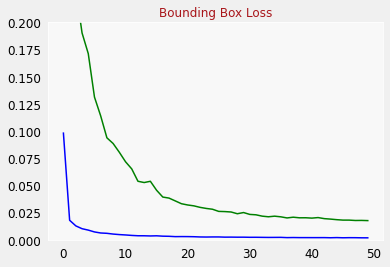

In [24]:
plot_metrics("loss", "Bounding Box Loss", ylim=0.2)

In [25]:
def intersection_over_union(pred_box, true_box):

    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    #Calculate coordinates of overlap area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    #Calculates area of true and predicted boxes
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    #Calculates overlap area and union area.
    overlap_area = np.maximum((xmax_overlap - xmin_overlap),0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    # Defines a smoothing factor to prevent division by 0
    smoothing_factor = 1e-10

    #Updates iou score
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

#Makes predictions
original_images, normalized_images, normalized_bboxes = dataset_to_numpy_with_original_bboxes_util(visualization_validation_dataset, N=500)
predicted_bboxes = model.predict(normalized_images, batch_size=32)


#Calculates IOU and reports true positives and false positives based on IOU threshold
iou = intersection_over_union(predicted_bboxes, normalized_bboxes)
iou_threshold = 0.5

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Number of predictions where iou > threshold(0.5): 253
Number of predictions where iou < threshold(0.5): 247


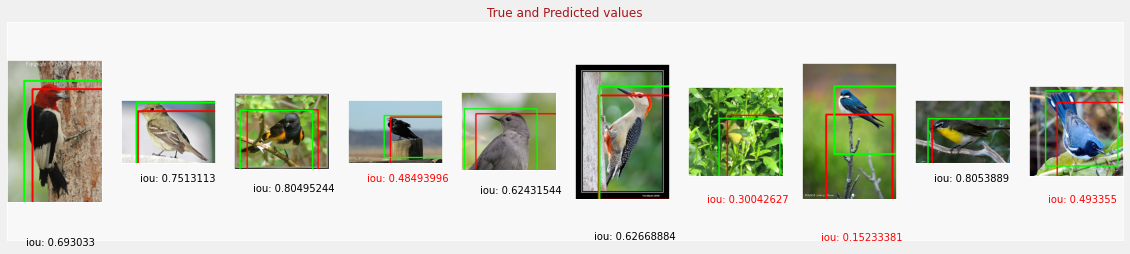

In [26]:
n = 10
indexes = np.random.choice(len(predicted_bboxes), size=n)

iou_to_draw = iou[indexes]
norm_to_draw = original_images[indexes]
display_digits_with_boxes(original_images[indexes], predicted_bboxes[indexes], normalized_bboxes[indexes], iou[indexes], "True and Predicted values", bboxes_normalized=True)